In [1]:
import os

import cv2

import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, AveragePooling2D
from tensorflow.python.keras import regularizers

from keras.callbacks import EarlyStopping, ModelCheckpoint

from matplotlib import pyplot as plt
import imghdr

import imagesize
from PIL import Image

%config Completer.use_jedi = False

In [ ]:
 def remove_wrong_picutres(directory_name: str):
    supported_extensions = ['bmp', 'jpg', 'jpeg', 'png']

    for image_directory in os.listdir(directory_name):
        i = 0
        cwd = os.path.join(directory_name, image_directory)
        for image_filename in os.listdir(os.path.join(directory_name, image_directory)):
            image_path = os.path.join(directory_name, image_directory, image_filename)

            filename_fragments = image_filename.split(sep='.')
            image_extension = filename_fragments.pop()

            if image_extension not in supported_extensions:
                try:
                    im = Image.open(image_path)
                    im.verify()
                    im = Image.open(image_path).convert('RGB')
                    im.save(f"{cwd}\\{str(i)}.jpeg")

                    print(f"{image_path} was converted successfully.")
                    image_path = cwd + '\\' + str(i) + ".jpeg"
                    i = i + 1
                    im.close()

                except Exception:
                    print("{} is a corrupt image and will be removed.".format(image_path))
                    os.remove(image_path)
                    continue

            file_size_kb = os.stat(image_path).st_size / 1024
            if file_size_kb < 16:
                os.remove(image_path)

            width, height = imagesize.get(image_path)
            aspect_ratio = max(width, height) / min(width, height)
            if aspect_ratio > 3.6:
                os.remove(image_path)

            if image_extension in supported_extensions:
                try:
                    image = cv2.imread(image_path) 
                except Exception:
                    print("File {} could not be opened and will be removed.".format(image_path))
                    os.remove(image_path)
                    print("{} is removed.".format(image_path))
                    continue
            else:
                print("Invalid image: {}".format(image_path))
                os.remove(image_path)
                print("{} is removed.".format(image_path))

In [54]:
remove_wrong_picutres('../images_v2')

In [2]:
dataset_directory = os.path.join('../images_v2')
data = tf.keras.preprocessing.image_dataset_from_directory(dataset_directory, batch_size=16, image_size=(256, 256))

Found 16199 files belonging to 3 classes.


In [3]:
iterator = data.as_numpy_iterator()

In [4]:
batch = iterator.next()

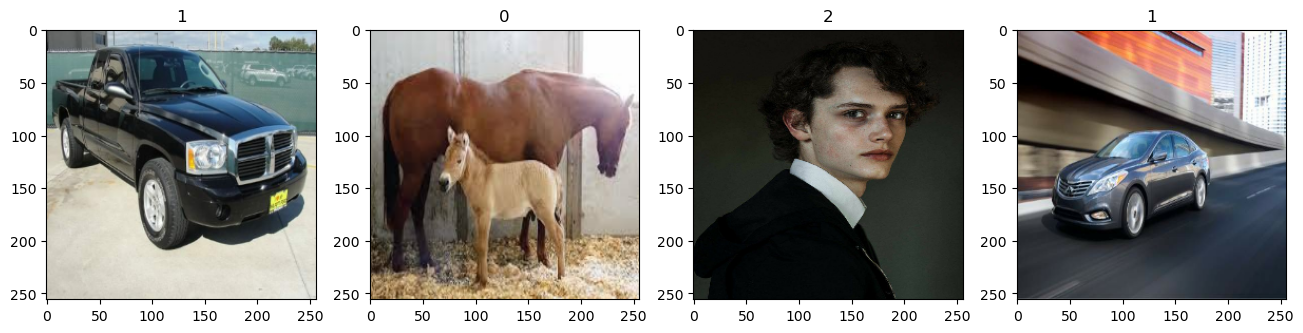

In [5]:
figure, ax = plt.subplots(ncols=4, figsize=(16, 16))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
data = data.map(lambda x, y: (x / 255, y))
scaled_iterator = data.as_numpy_iterator()

In [7]:
batch_count = len(data)
train_size = int(batch_count * 0.6)
test_size = int(batch_count * 0.2)
validation_size = int(batch_count * 0.2)

In [8]:
train_data = data.take(train_size)
test_data = data.skip(train_size).take(test_size)
validation_data = data.skip(train_size).skip(test_size).take(validation_size)

In [9]:
model = Sequential()

model.add(Conv2D(16, (3, 3), 1, input_shape=(256,256,3), activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(64, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(32, activation = tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(Dropout(0.5))
model.add(Dense(16, activation = tf.keras.layers.LeakyReLU(alpha=0.05)))
model.add(Dense(3, activation = 'softmax'))

In [10]:
model.compile(tf.keras.optimizers.Adam(0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [12]:
log_directory = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [14]:
import datetime
now = datetime.datetime.now()
formatted_date = str("{}-{}-{}-{}-{}-{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second))
model_checkpoint = ModelCheckpoint('../saved_models/edited_model-'+ formatted_date + '.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [15]:
history = model.fit(train_data, epochs=10, validation_data=validation_data, callbacks=[tensorboard_callback, early_stopping, model_checkpoint])

Epoch 1/10
607/607 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.7336
Epoch 1: val_loss improved from inf to 0.25444, saving model to saved_models\edited_model-2023-2-4-15-23-3.h5
607/607 [==============================] - 224s 367ms/step - loss: 0.6334 - accuracy: 0.7336 - val_loss: 0.2544 - val_accuracy: 0.9050
Epoch 2/10
607/607 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.9054
Epoch 2: val_loss improved from 0.25444 to 0.15260, saving model to saved_models\edited_model-2023-2-4-15-23-3.h5
607/607 [==============================] - 191s 315ms/step - loss: 0.2828 - accuracy: 0.9054 - val_loss: 0.1526 - val_accuracy: 0.9493
Epoch 3/10
607/607 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9423
Epoch 3: val_loss improved from 0.15260 to 0.13096, saving model to saved_models\edited_model-2023-2-4-15-23-3.h5
607/607 [==============================] - 192s 316ms/step - loss: 0.1754 - accuracy: 0.9423 - val_loss:

In [34]:
from keras import models

In [40]:
model.save('../saved_models/' + formatted_date + '.h5')

In [9]:
saved_model = models.load_model('../saved_models/maxpooling_leakyrelu/edited_model-2023-2-2-16-11-6.h5')

In [10]:
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [16]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

accuracy = BinaryAccuracy()
precision = Precision()
recall = Recall()

In [18]:
for batch in test_data.as_numpy_iterator():
    x, y = batch
    one_hot_y = tf.one_hot(indices=y, depth=3)
    yhat = model.predict(x)
    precision.update_state(one_hot_y, yhat)
    recall.update_state(one_hot_y, yhat)
    accuracy.update_state(one_hot_y, yhat)

In [19]:
print("Precision: {}".format(precision.result().numpy()))
print("Recall: {}".format(recall.result().numpy()))
print("Accuracy: {}".format(accuracy.result().numpy()))

Precision: 0.9500465393066406
Recall: 0.9474009871482849
Accuracy: 0.9658623337745667
